In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas
import numpy

# Input data

In [2]:
data = pandas.read_csv('input.csv', index_col=False)

data.head()

,event,particle,hit,x,y
0,0,10000100,100000640,247.365072,968.954400
1,0,10000100,100000830,494.712256,1937.881317
2,0,10000100,100001150,742.059440,2906.808234
3,0,10000100,100000010,989.406625,3875.735151
4,0,10000100,100000560,1236.753809,4844.662068


# Tracks Clustering

## One event

In [3]:
toy_event_id = 0
event = data[data.event.values == toy_event_id]

In [4]:
from hough import Hough

h = Hough(n_theta_bins=5000, n_radius_bins=1000, min_radius=400., min_hits=6)
h.predict(event.x.values, event.y.values)

matrix_hough = h.matrix_hough_
track_inds = h.track_inds_
track_params = h.track_params_

In [5]:
print "List of tracks. A track is a list of hit indexes. One hit can belong to several recognized tracks."
track_inds

List of tracks. A track is a list of hit indexes. One hit can belong to several recognized tracks.


array([array([42, 43, 44, 45, 46, 47]),
       array([41, 42, 43, 44, 45, 46, 47]),
       array([40, 41, 42, 43, 44, 45, 46, 47]),
       array([42, 43, 44, 45, 46, 47]), array([26, 27, 28, 29, 30, 31]),
       array([25, 26, 27, 28, 29, 30, 31]),
       array([24, 25, 26, 27, 28, 29, 30, 31]),
       array([25, 26, 27, 28, 29, 30]), array([26, 27, 28, 29, 30, 31]),
       array([112, 113, 114, 115, 116, 117, 118, 119]),
       array([113, 114, 115, 116, 117, 118, 119]),
       array([114, 115, 116, 117, 118, 119]),
       array([ 81, 115, 116, 117, 118, 119]),
       array([ 25,  47,  81, 114, 115, 116]),
       array([ 25,  47,  81, 115, 116, 117]),
       array([70, 75, 76, 77, 78, 79]), array([70, 75, 76, 77, 78, 79]),
       array([70, 74, 75, 76, 77, 78]), array([74, 75, 76, 77, 78, 79]),
       array([72, 73, 74, 75, 76, 77, 78, 79]),
       array([70, 73, 74, 75, 76, 77, 78, 79]),
       array([70, 75, 76, 77, 78, 79]),
       array([ 68,  83,  84,  85,  86,  87, 113]),
      

The following function merge hits of track from one cluster.

In [6]:
def merge_tracks(tracks_inds, cluster_labels):
    
    new_track_inds = []
    
    for one_label in numpy.unique(cluster_labels):
        
        one_label_tracks = tracks_inds[cluster_labels == one_label]
        one_new_track = numpy.unique(numpy.concatenate(tuple(one_label_tracks)))
        
        new_track_inds.append(one_new_track)
        
    return numpy.array(new_track_inds)

Tracks clustering and merging hit of tracks from one cluster.

In [7]:
from sklearn.cluster import MeanShift
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
scaled_params = ss.fit_transform(numpy.array(track_params))

km = MeanShift(bandwidth=0.1)
km.fit(scaled_params)

cluster_labels = km.labels_
cluster_centers = km.cluster_centers_

new_track_inds = merge_tracks(track_inds, cluster_labels)

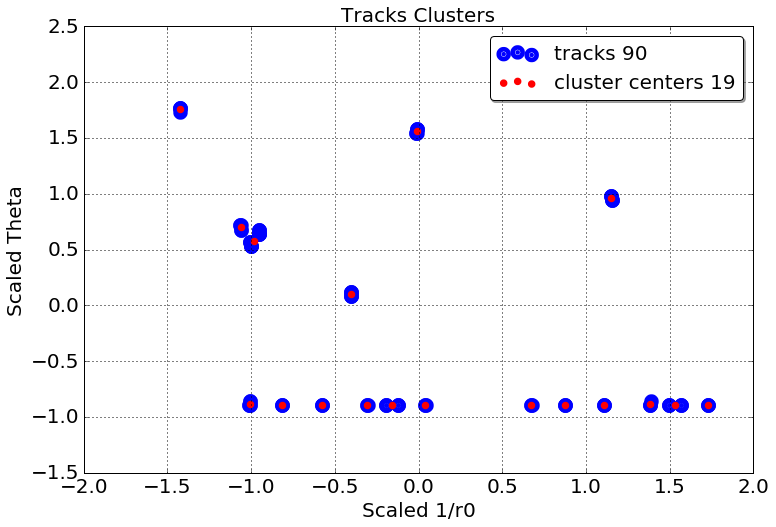

In [8]:

plt.figure(figsize=(12,8))
plt.scatter(scaled_params[:, 0], scaled_params[:, 1], color='b', label='tracks %d' % len(scaled_params), linewidth=10)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], color='r', label='cluster centers %d' % len(cluster_centers), linewidth=3)

plt.title("Tracks Clusters", fontsize=20)
plt.legend(loc="best", prop={'size':20},  shadow=True, fancybox=True)
plt.xlabel('Scaled 1/r0', fontsize=20)
plt.ylabel('Scaled Theta', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(linewidth=1)
plt.show()

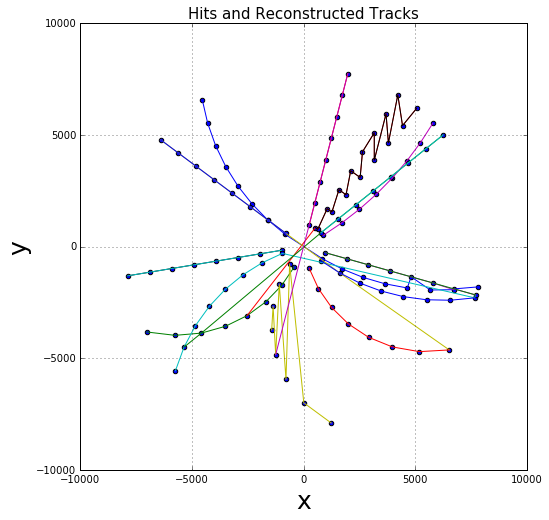

In [9]:
plt.figure(figsize=(8,8))
plt.scatter(event.x.values, event.y.values)

for track in new_track_inds:
    
    xs = event.x.values[track]
    ys = event.y.values[track]
    
    sort_inds = xs.argsort()
    
    plt.plot(xs[sort_inds], ys[sort_inds])

plt.title("Hits and Reconstructed Tracks", size=15)
plt.xlabel("x", size=25)
plt.ylabel("y", size=25)
plt.grid(b=1)
plt.show()

## Hough Transform Modification

In [10]:
from hough import Hough
from regression import TrackRegression
from sklearn.cluster import MeanShift
from sklearn.preprocessing import StandardScaler

class ModifiedHough(Hough):
    
    
    def __init__(self, n_theta_bins=5000, n_radius_bins=1000, min_radius=400., min_hits=7, bandwidth=0.1):
        
        self.bandwidth = bandwidth # Parameters affects the tracks clustering quality
        
        Hough.__init__(self, n_theta_bins, n_radius_bins, min_radius, min_hits)
    
    def merge_tracks(tracks_inds, cluster_labels):
    
        new_track_inds = []

        for one_label in numpy.unique(cluster_labels):

            one_label_tracks = tracks_inds[cluster_labels == one_label]
            one_new_track = numpy.unique(numpy.concatenate(tuple(one_label_tracks)))

            new_track_inds.append(one_new_track)

        return numpy.array(new_track_inds)
    
    def tracks_clustering(self, track_inds, track_params):
        
        ss = StandardScaler()
        scaled_params = ss.fit_transform(numpy.array(track_params))

        km = MeanShift(bandwidth=self.bandwidth)
        km.fit(scaled_params)

        cluster_labels = km.labels_
        cluster_centers = km.cluster_centers_

        new_track_inds = merge_tracks(track_inds, cluster_labels)
        
        return new_track_inds

    
    def predict(self, x, y): # This method must be!
        
        Hough.predict(self, x, y)
        
        self.track_inds_ = self.tracks_clustering(self.track_inds_, self.track_params_) # This attribute must be!

In [26]:
from recognizer import TrackRecognizer

method = ModifiedHough(n_theta_bins=5000, n_radius_bins=1000, min_radius=400., min_hits=6, bandwidth=0.001)

tr = TrackRecognizer(method=method)
results = tr.predict(data)

results.head()

,event,track,hit,x,y
0,0,0,100001210,246.378914,-969.173581
1,0,0,100000120,664.958203,-1886.221246
2,0,0,100001550,1251.738174,-2726.380667
3,0,0,100001190,2002.381957,-3462.725299
4,0,0,100001630,2911.944353,-4064.551647


## Quality metrics

In [27]:
from metrics import RecognitionQuality

rq = RecognitionQuality(data, results, track_eff_threshold=0.8, min_hits_per_track=6)
report_event, report_tracks = rq.calculate()

In [28]:
report_event.mean(axis=0)

Event                       99.500000
ReconstructionEfficiency     0.996979
GhostRate                    0.196387
CloneRate                    1.121261
AvgTrackEfficiency           0.939000
dtype: float64